In [1]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os

Using TensorFlow backend.


## Load from keras.datasets.cifar10¶ 

In [2]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

170500096/170498071 [==============================] - 6s 0us/step


## Preprocessing

In [3]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)
print('train:', x_train.shape, y_train.shape)
print('train:', x_test.shape, y_test.shape)

train: (50000, 3072) (50000, 10)
train: (10000, 3072) (10000, 10)


## Create Model(MLP)
- Add Batch Nomalization Layer befor each DenseLayer

In [4]:
h_list = [512, 256, 128]

def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, reg={'L2':1e-5}):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            #x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            #x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

## HyperParameters

In [5]:
EPOCHS = 50
BATCH_SIZE_LIST = [2, 16, 32, 128, 256]
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
#set optimizer
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)

## Training

In [6]:

def model_train(model=model, optimizer=optimizer, 
                train = (x_train, y_train), valid = (x_test, y_test),
                e=EPOCHS, bs = BATCH_SIZE_LIST[-1] ):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, epochs=e, batch_size=bs, shuffle=True)
    
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    record = {'train_loss':train_loss,
              'valid_loss':valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc}
    return model, record
    

## Training

In [7]:
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
model , record = model_train(model, optimizer)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.9062 - acc: 0.3559 - val_loss: 1.7948 - val_acc: 0.3930
Epoch 2/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.5646 - acc: 0.4581 - val_loss: 1.5980 - val_acc: 0.4430
Epoch 3/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.4626 - acc: 0.4936 - val_loss: 1.6274 - val_acc: 0.4274
Epoch 4/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.3926 - acc: 0.5156 - val_loss: 1.5661 - val_acc: 0.4485
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.3302 - acc: 0.5376 - val_loss: 1.5277 - val_acc: 0.4665
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.2853 - acc: 0.5533 - val_loss: 1.5073 - val_acc: 0.4791
Epoch 7/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.2426 - acc: 0.5698 - val_loss: 1.5274 - val_acc

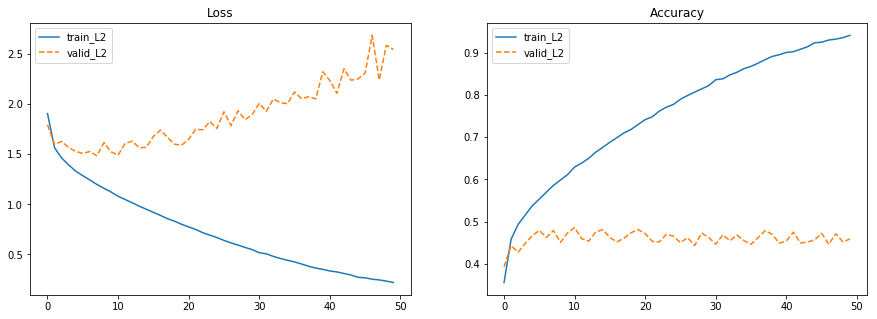

In [8]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()

            
plot_result(record, 'L2', ax1, ax2)
plt.show()

## Batch Size Search

In [9]:
h_list = [512, 256, 128]
result = {}
BATCH_SIZE_LIST = [512, 256, 128, 64]
for b in BATCH_SIZE_LIST:
    EPOCHS = 50
    LEARNING_RATE = 1e-3
    MOMENTUM = 0.95
    
    model = build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
                      hidden=h_list, reg={'L2':1e-5})
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=0.95)
    model, record = model_train(model, optimizer, train = (x_train, y_train), valid = (x_test, y_test),
                e=EPOCHS, bs = b)
    result['BATCH_SIZE_' + str(b)] = record

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.0414 - acc: 0.3165 - val_loss: 1.9421 - val_acc: 0.3416
Epoch 2/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.6390 - acc: 0.4311 - val_loss: 1.7082 - val_acc: 0.4074
Epoch 3/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.5394 - acc: 0.4643 - val_loss: 1.6077 - val_acc: 0.4385
Epoch 4/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.4677 - acc: 0.4896 - val_loss: 1.5779 - val_acc: 0.4519
Epoch 5/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.4149 - acc: 0.5109 - val_loss: 1.5708 - val_acc: 0.4504
Epoch 6/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.3675 - acc: 0.5260 - val_loss: 1.5357 - val_acc: 0.4641
Epoch 7/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.3227 - acc: 0.5428 - val_loss: 1.5010 - val_acc

Epoch 10/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.1200 - acc: 0.6165 - val_loss: 1.5378 - val_acc: 0.4668
Epoch 11/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0859 - acc: 0.6264 - val_loss: 1.5395 - val_acc: 0.4738
Epoch 12/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0484 - acc: 0.6421 - val_loss: 1.4963 - val_acc: 0.4928
Epoch 13/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0112 - acc: 0.6546 - val_loss: 1.5178 - val_acc: 0.4843
Epoch 14/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.9780 - acc: 0.6672 - val_loss: 1.5185 - val_acc: 0.4874
Epoch 15/50
50000/50000 [==============================] - 2s 35us/step - loss: 0.9477 - acc: 0.6758 - val_loss: 1.6179 - val_acc: 0.4638
Epoch 16/50
50000/50000 [==============================] - 2s 35us/step - loss: 0.9177 - acc: 0.6878 - val_loss: 1.5313 - val_acc: 0.4906
Epoch 17/50
50000/50000 [=========

50000/50000 [==============================] - 3s 59us/step - loss: 0.8080 - acc: 0.7217 - val_loss: 1.6197 - val_acc: 0.4725
Epoch 20/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.7772 - acc: 0.7336 - val_loss: 1.9250 - val_acc: 0.4380
Epoch 21/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.7524 - acc: 0.7404 - val_loss: 1.8337 - val_acc: 0.4560
Epoch 22/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.7245 - acc: 0.7515 - val_loss: 1.7406 - val_acc: 0.4674
Epoch 23/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.7002 - acc: 0.7616 - val_loss: 1.8638 - val_acc: 0.4542
Epoch 24/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.6813 - acc: 0.7689 - val_loss: 1.8552 - val_acc: 0.4602
Epoch 25/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.6648 - acc: 0.7716 - val_loss: 1.7171 - val_acc: 0.4905
Epoch 26/50
50000/50000 [=====================

Epoch 28/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.8228 - acc: 0.7127 - val_loss: 1.6687 - val_acc: 0.4780
Epoch 29/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.7979 - acc: 0.7178 - val_loss: 1.8450 - val_acc: 0.4628
Epoch 30/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.7899 - acc: 0.7235 - val_loss: 1.8027 - val_acc: 0.4509
Epoch 31/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.7830 - acc: 0.7256 - val_loss: 1.7219 - val_acc: 0.4818
Epoch 32/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.7539 - acc: 0.7349 - val_loss: 1.8329 - val_acc: 0.4527
Epoch 33/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.7464 - acc: 0.7391 - val_loss: 1.7847 - val_acc: 0.4655
Epoch 34/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.7349 - acc: 0.7441 - val_loss: 1.7002 - val_acc: 0.4856
Epoch 35/50
50000/50000 [==

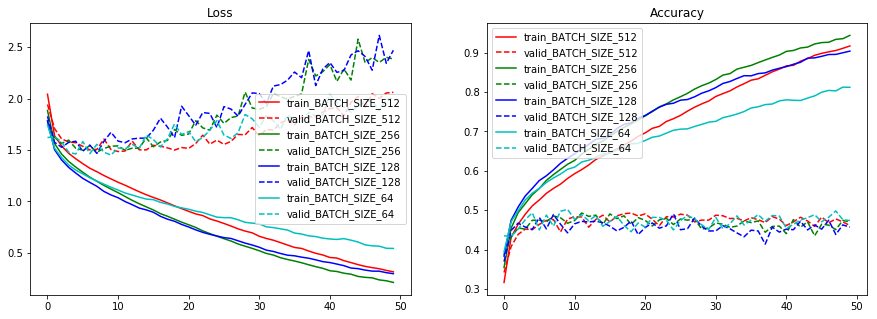

In [11]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
color = ['r', 'g', 'b', 'c']
for idx, k in enumerate(result.keys()):
    for idx2, kk in enumerate(result[k].keys()):
        if kk[0] == 't':
            L, c, line= 'train_' + k, color[idx], '-' 
        else:
            L, c, line = 'valid_' + k, color[idx], '--'
        
        if kk[-4:] == 'loss':
            ax1.plot(range(len(result[k][kk])), result[k][kk], line, label=L, color = c)
        else:
            ax2.plot(range(len(result[k][kk])), result[k][kk], line, label=L, color = c)
        ax1.legend()
        ax2.legend()
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')